## Reward Signals
Data Collected at Rutgers University by David Smith

### Variable Key

#### Raw Data Names
- soc_win - affective feedback in a trial. 0 lose and 1 is win 
- partner - 0 is nonsocial and 1  is social
- deckchoice - 1 or 2 based on participant choice of option. 1 = star, 2 = pentagon
- lapse1 and lapse2 - participant did not respond in respective decision phase

#### Derived Data Names
##### Columns renamed
- index - renamed from raw data index
- choice - renamed from raw data column 'deckchoice'
- is_social - renamed from raw data column 'partner'
- aff_feedback_curr - renamed from raw data 'soc_win'

##### Columns derived
- aff_feedback_prev - aff_feedback_curr shifted by one trial to reflect trial -1
- prev_is_social - is_social shifted by one trial to reflect trial -1
- prev_aff_fb - affective feedback in the previous trial, 0 is lose and 1 is win
- star_points - known value of option 1 
- pentagon_points - known value of option 2 
- diff_point - star_points - pentagon_points

In [2]:
import pandas as pd
from utility import *

#subject class for easy dataframe access
class Subject():

    def __init__(self, subnum):
        self.subnum = subnum
        self.matfiles = [i for i in file_list if str(subnum) in i]
        self.df = make_derived_df(self.matfiles)

#### Logistic Models

In [3]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt 
#list of regressors
subset = ['choice', 'is_social','prev_diff_points', 'aff_feedback_prev', 'prev_is_social']

#gets beta weights predicting choice 
def get_model_weights(df):
    
    #data labels, recode 1 and 2 as 0 and 1
    label = df.choice - 1
    
    #z-score all regresors in analysis
    data= Subject(i).df[subset].iloc[:, 1:].apply(stats.zscore)
    
    #make interactions
    
    '''
    Dave- 
    1. current_social_v_nonsocial(t) = 1 and -1
    2. point_diff(t-1) = star - pentagon value
    3. affective_feedback(t-1) = 1 (win) and -1 (loss)
    4. prev_social_v_nonsocial(t-1) = 1 and -1
    5. aff*soc interaction = zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    6. value*soc interaction = zscore(point_diff(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    7. value*aff interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1))
    8. value*aff*soc interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    '''
    #5. aff*soc interaction = zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    data['prev_aff * is_socail'] = data['aff_feedback_prev'] * data['is_social']
    
    #6. value*soc interaction = zscore(point_diff(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    data['prev_diff_points * is_social'] = data['prev_diff_points'] * data['is_social']
    
    #7. value*aff interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1))
    data['prev_diff_points * aff_feedback_prev'] = data['prev_diff_points'] * data['aff_feedback_prev']
    
    # 8. value*aff*soc interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    data['prev_diff_points * is_social * aff_feedback_prev'] = data['prev_diff_points'] * data['is_social'] * data['aff_feedback_prev']
    
    #run logistic, return coeff list 
    y = np.array(label.values.tolist()).ravel()
    x = np.array(data.values.tolist())
    
    '''
    This class implements regularized logistic regression using the 
    ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers. 
    Note that regularization is applied by default.
    '''
    clf = LogisticRegression()
    clf.fit(x, y)
    
    return clf.coef_[0].tolist()

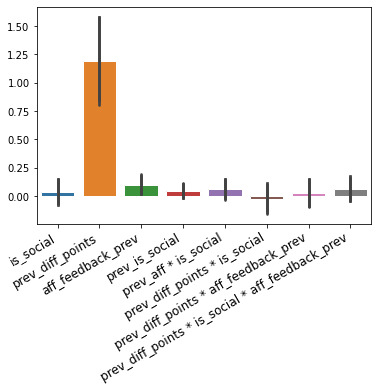

In [4]:
#get subject list 
subject_list = (pd.Series([(i.split('/'))[1] for i in file_list]).unique())

#make dataframe where subjects are rows and B0 per regressor are columns 
df = pd.DataFrame()
intercept = []

for i in subject_list: 
    x = list({i: get_model_weights(Subject(i).df)}.values())[0]
    df[i] = x
    
df = df.transpose()

#len(df.columns) == len(data.columns -1)
df.columns = ['is_social',
              'prev_diff_points',
              'aff_feedback_prev',
              'prev_is_social',
              'prev_aff * is_social',
              'prev_diff_points * is_social',
              'prev_diff_points * aff_feedback_prev',
              'prev_diff_points * is_social * aff_feedback_prev'
]

#plot
fig, bar = plt.subplots()
ax = sns.barplot(data=df)

bar.set_xticklabels(df.columns, fontsize=12, rotation=30, ha= 'right');
sns.set_style("whitegrid")
ax = sns.barplot(data=df)#

In [5]:
#subset = ['rating', 'is_social','is_catch', 'aff_feedback_curr']

In [34]:


for i in subject_list:
    df = Subject(i).df
    df = df.loc[:, ['rating', 'is_social','is_catch', 'aff_feedback_curr', 'Npoints']]

    print(df)
   

    rating  is_social  is_catch  aff_feedback_curr
16    0.00          1         0                  0
17    0.00          0         0                  0
18    0.00          1         0                  0
19    0.00          0         0                  0
20    0.00          1         0                  1
21    0.45          0         1                  0
22    0.00          1         0                  1
23    0.00          0         0                  0
24    0.00          1         0                  1
25    0.00          1         0                  0
26    0.00          0         0                  0
27    0.00          0         0                  1
28    0.00          0         0                  0
29    0.00          1         0                  1
30    0.00          1         0                  1
31    0.00          1         0                  1
32    0.00          1         0                  1
33    0.00          0         0                  1
34    0.00          0         0

     rating  is_social  is_catch  aff_feedback_curr
3      0.00          1         0                  0
4      0.00          1         0                  1
5      0.00          1         0                  1
6      0.00          0         0                  1
7      0.00          0         0                  1
..      ...        ...       ...                ...
140    0.00          0         0                  0
141    0.00          0         0                  0
142    0.00          0         0                  1
143    0.00          1         0                  1
144   -7.05          0         1                  0

[142 rows x 4 columns]
     rating  is_social  is_catch  aff_feedback_curr
4      0.00          1         0                  0
5      0.00          1         0                  0
6      0.00          1         0                  0
7      0.00          0         0                  0
8      6.25          0         1                  1
..      ...        ...       ...        